In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/MyDrive/MyDrive/Data/casos_covid_provincia.csv', sep=';', decimal=',')

In [4]:
df.head()

,fecha,provincia,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
0,01/01/2020,Alicante,0,0,0,0,0,0
1,01/01/2020,Albacete,0,0,0,0,0,0
2,01/01/2020,Almeria,0,0,0,0,0,0
3,01/01/2020,Avila,0,0,0,0,0,0
4,01/01/2020,Barcelona,0,0,0,0,0,0


In [5]:
df.columns

Index(['fecha', 'provincia', 'num_casos', 'num_casos_prueba_pcr',
       'num_casos_prueba_test_ac', 'num_casos_prueba_ag',
       'num_casos_prueba_elisa', 'num_casos_prueba_desconocida'],
      dtype='object')

In [6]:
df.fecha=pd.to_datetime(df.fecha, format="%d/%m/%Y")

In [7]:
df.head()

,fecha,provincia,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
0,2020-01-01,Alicante,0,0,0,0,0,0
1,2020-01-01,Albacete,0,0,0,0,0,0
2,2020-01-01,Almeria,0,0,0,0,0,0
3,2020-01-01,Avila,0,0,0,0,0,0
4,2020-01-01,Barcelona,0,0,0,0,0,0


In [8]:
madrid_df = df[df["provincia"] == "Madrid"]
madrid_df.head()

,fecha,provincia,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
27,2020-01-01,Madrid,1,1,0,0,0,0
80,2020-01-02,Madrid,0,0,0,0,0,0
133,2020-01-03,Madrid,0,0,0,0,0,0
186,2020-01-04,Madrid,0,0,0,0,0,0
239,2020-01-05,Madrid,0,0,0,0,0,0


In [9]:
madrid_df.columns

Index(['fecha', 'provincia', 'num_casos', 'num_casos_prueba_pcr',
       'num_casos_prueba_test_ac', 'num_casos_prueba_ag',
       'num_casos_prueba_elisa', 'num_casos_prueba_desconocida'],
      dtype='object')

In [10]:
madrid_df2 = madrid_df.set_index('fecha').resample('W')[['num_casos']].sum()

In [11]:
madrid_df2.head()

,num_casos
fecha,
2020-01-05,1
2020-01-12,3
2020-01-19,7
2020-01-26,8
2020-02-02,22


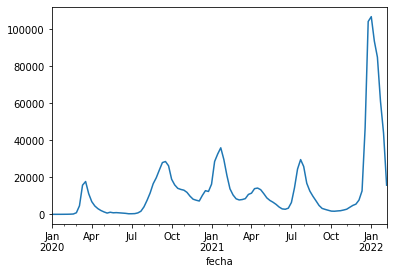

In [12]:
madrid_df2['num_casos'].plot()

In [13]:
# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':madrid_df2.index,'y':madrid_df2.num_casos})
#ts['cap'] = 30000 # unused in linear growth
#ts['floor'] = 0 # unused in linear growth
ts.head()

,ds,y
fecha,,
2020-01-05,2020-01-05,1
2020-01-12,2020-01-12,3
2020-01-19,2020-01-19,7
2020-01-26,2020-01-26,8
2020-02-02,2020-02-02,22


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


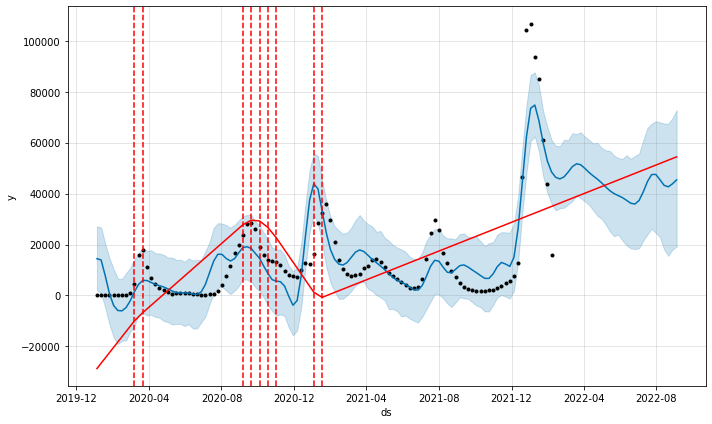

In [14]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
# instantiate the model and fit the timeseries
prophet = Prophet(changepoint_range=0.5,changepoint_prior_scale=0.5)
prophet.fit(ts)

# create a future data frame 
future = prophet.make_future_dataframe(periods=30, freq='W') #documentación para ver cómo poner semanas
forecast = prophet.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),prophet,forecast)
#fig

In [15]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-05,14428.648344,2027.486232,27116.794475
1,2020-01-12,13935.597015,698.522064,26722.866072
2,2020-01-19,7670.261501,-4851.746612,20195.422303
3,2020-01-26,709.630400,-11380.820214,14624.902403
4,2020-02-02,-3929.852002,-16357.178398,10408.053244


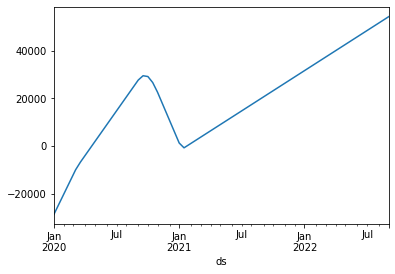

In [16]:
forecast.set_index('ds')['trend'].plot()

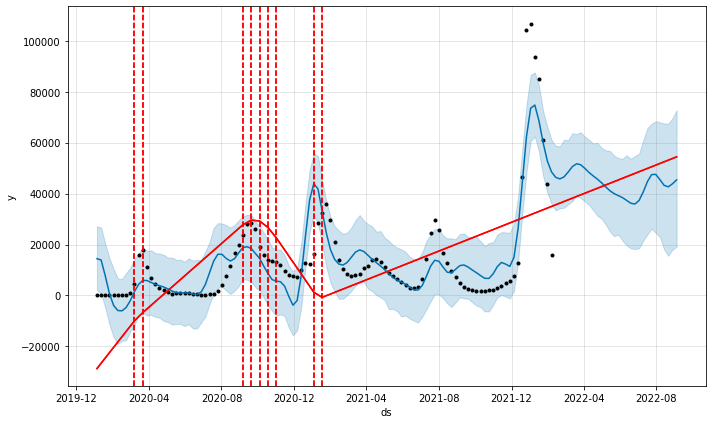

In [17]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(),prophet,forecast)
fig

In [18]:
# Guardamos el resultado en un fichero csv separado por comas. 
forecast.to_csv('covid_madrid.csv',  index=False, sep=";", decimal=",")